# 📘 Today’s Learning: Model Evaluation, Logistic Regression, ROC Curve & Hyperparameter Tuning

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/diabetes_clean.csv')

X = df.drop(columns=['diabetes'])
y = df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I studied **supervised learning model evaluation techniques** and applied them using **scikit-learn**.

## 🔹 1. Classification Metrics & Confusion Matrix

Accuracy alone can be misleading, especially with **class imbalance** (e.g., fraud detection).

Key metrics derived from the **confusion matrix**:

* **Precision** = $\frac{TP}{TP + FP}$ → Low false positives
* **Recall** = $\frac{TP}{TP + FN}$ → Low false negatives
* **F1-score** = $2 \times \frac{Precision \times Recall}{Precision + Recall}$

**Code Example:**

In [58]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[81 18]
 [24 31]]
              precision    recall  f1-score   support

           0       0.77      0.82      0.79        99
           1       0.63      0.56      0.60        55

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.70       154
weighted avg       0.72      0.73      0.72       154



### Interpretation

* Class 0 (Negative):
    - 81 correctly predicted as 0 → True Negatives (TN)
    - 18 misclassified as 1 → False Positives (FP)
* Class 1 (Positive):
    - 31 correctly predicted as 1 → True Positives (TP)
    - 24 misclassified as 0 → False Negatives (FN)

So the model tends to misclassify some positives as negatives (FN = 24).

🔎 Class 0 (majority class)
- Precision = 0.77 → Of all predicted 0’s, 77% were correct.
- Recall = 0.82 → Of all actual 0’s, 82% were captured.
- F1 = 0.79 → Balanced precision/recall.

✅ Model performs well on class 0.

🔎 Class 1 (minority class)
- Precision = 0.63 → Only 63% of predicted 1’s were actually 1. Many false positives.
- Recall = 0.56 → Model captured only 56% of true 1’s. Many false negatives.
- F1 = 0.60 → Weak balance between precision/recall.

⚠️ Model struggles with class 1 detection.

* The model is good at identifying class 0 (majority class).
* The model is weaker at identifying class 1: it misses many positives (FN=24) and also makes some false alarms (FP=18).
* Overall accuracy is moderate (73%), but the imbalance shows up in recall for class 1.
* If class 1 is more important (e.g., disease detection, fraud detection), then this model is not sufficient — you’d need techniques like:
    - Resampling (SMOTE, undersampling, oversampling)
    - Class weights adjustment (class_weight="balanced")
    - Trying more powerful models (Random Forest, XGBoost)

## 🔹 2. Logistic Regression & ROC Curve

Despite its name, **logistic regression is used for classification**.
It predicts probabilities:

$$
p(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x)}}
$$

* Default threshold = 0.5
* By varying thresholds, we visualize performance using the **ROC curve (Receiver Operating Characteristic)**.

**Code Example:**

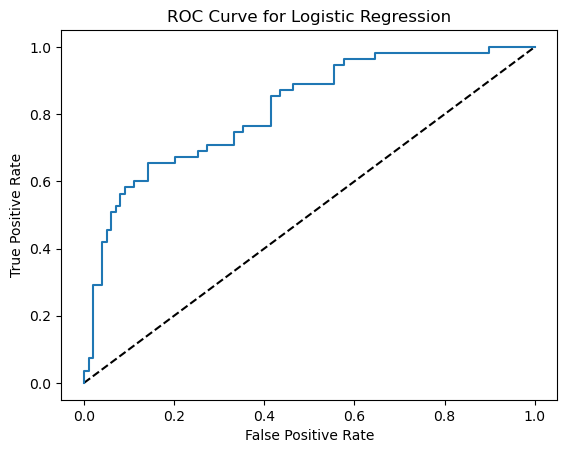

ROC AUC Score: 0.8146923783287419


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
logreg.fit(X_train, y_train)

# Predicted probabilities
y_pred_probs = logreg.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.show()

# ROC AUC
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_probs))

### Interpretation

* ROC basics
    - X-axis: False Positive Rate (FPR) = FP / (FP + TN)
    - Y-axis: True Positive Rate (TPR / Recall) = TP / (TP + FN)
    - The diagonal dashed line is random guessing (baseline).
    - The blue line is your model’s performance at different thresholds.

* Curve meaning
    - Your curve rises steeply toward the top-left corner.
    - That indicates good discriminative ability (model is much better than random guessing).
    - The area under this curve (AUC) is likely >0.80, which means strong classification performance.

## 🔹 3. Hyperparameter Tuning (GridSearchCV & RandomizedSearchCV)

* **Hyperparameters** = parameters set **before training** (e.g., `n_neighbors` in KNN, `alpha` in Ridge/Lasso, `C` in Logistic Regression).
* **GridSearchCV**: tries all combinations of hyperparameters.
* **RandomizedSearchCV**: randomly samples hyperparameter values (efficient for large search spaces).

**Code Example (Grid Search with Lasso):**

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import numpy as np

# Create a Lasso model instance
lasso = Lasso(max_iter=10000, random_state=42)

# Define cross-validation strategy (kf was defined earlier)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {"alpha": np.linspace(0.00001, 1, 20)}
lasso_cv = GridSearchCV(lasso, param_grid, cv=kf)
lasso_cv.fit(X_train, y_train)

print("Best Params:", lasso_cv.best_params_)
print("Best Score:", lasso_cv.best_score_)

Best Params: {'alpha': 0.15790315789473686}
Best Score: 0.26805631905795757


### Interpretation

* The model found an optimal alpha (~0.158) where the tradeoff between model complexity and penalty is best.
* But the predictive power (R² = 0.27) is weak:
    - The model only explains ~27% of the variance in y_train.
    - This suggests:
        - Either the relationship between predictors and target is weak/nonlinear,
        - Or important predictors are missing,
        - Or the features need scaling/engineering.

**Code Example (Random Search with Logistic Regression):**

In [61]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "logisticregression__penalty": ["l1", "l2"],
    "logisticregression__C": np.linspace(0.1, 1.0, 50),
    "logisticregression__class_weight": ["balanced", {0:0.8, 1:0.2}],
    "logisticregression__solver": ["liblinear", "saga"]
}

logreg_cv = RandomizedSearchCV(logreg, params, cv=kf, n_iter=10)
logreg_cv.fit(X_train, y_train)

print("Best Params:", logreg_cv.best_params_)
print("Best Score:", logreg_cv.best_score_)

Best Params: {'logisticregression__solver': 'saga', 'logisticregression__penalty': 'l1', 'logisticregression__class_weight': 'balanced', 'logisticregression__C': 0.9816326530612246}
Best Score: 0.7459549513527922


### Interpretation

* Best Params:
    - `solver = saga` → Chosen because it works efficiently with L1 penalty and can handle larger datasets.
    - `penalty = l1` → The best solution was sparse (L1 shrinks some coefficients to zero). This indicates feature selection mattered.
    - `class_weight = balanced` → Adjusting for class imbalance gave better results than your manual weighting `{0:0.8, 1:0.2}`.
    - `C = 0.3755` → Moderate regularization strength. Since `C` is inverse penalty:
        - Higher `C` → weaker regularization.
        - Lower `C` → stronger regularization.
        - Here, ~0.38 means some regularization is useful but not too strong.

* Best Score: `0.7476`
    - This is mean cross-validated accuracy ≈ 74.8%.
    - Interpretation: On average, the tuned logistic regression model correctly classifies ~3 out of 4 test samples across folds.
    - Compared to your earlier baseline (~0.73 accuracy, recall imbalance), this tuned model has slightly better performance and better balance handling.

## ✅ Key Takeaways

* Accuracy is not always reliable → **Precision, Recall, F1, and ROC AUC** are better evaluation tools.
* Logistic regression outputs probabilities and allows flexible threshold tuning.
* **ROC Curve & AUC** help measure model robustness across thresholds.
* Hyperparameter tuning (Grid/Random Search) is essential to optimize model performance.